### Import Libraries

In [1]:
# Import Libraries
from huggingface_hub import hf_hub_download
from PIL import Image
from transformers import DetrFeatureExtractor
from transformers import TableTransformerForObjectDetection
import torch
import os
import matplotlib.pyplot as plt
import json
import cv2
from PIL import Image, ImageDraw

c:\Users\kuria\miniconda3\envs\capstone\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pip show transformers

Name: transformers
Version: 4.34.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\users\kuria\miniconda3\envs\capstone\lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Set directory to where you have a bunch of images
main_wd = 'D:/UWA/cits5553/Dataset/Kose/90098'
os.chdir(main_wd)

# Get all files in the current working directory
all_files = [file for file in os.listdir() if file.endswith('.jpg')]

### 1. Table Recognition

c:\Users\kuria\miniconda3\envs\capstone\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection f

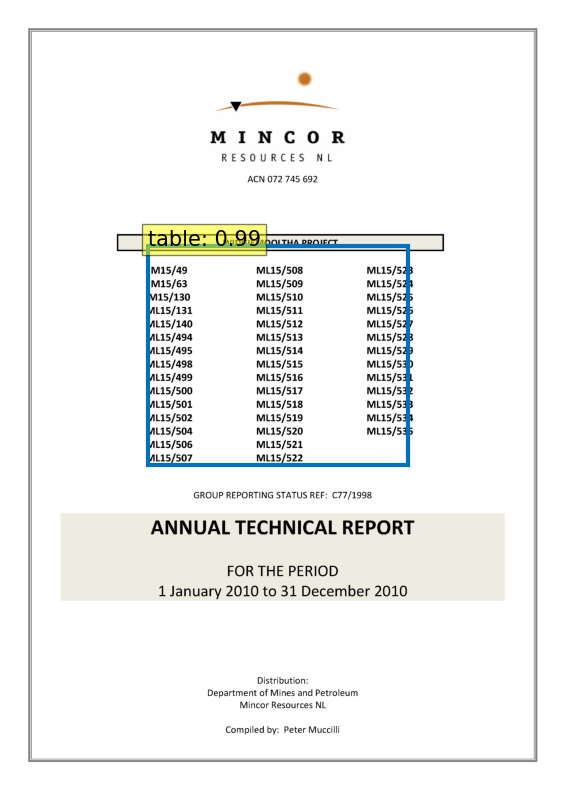

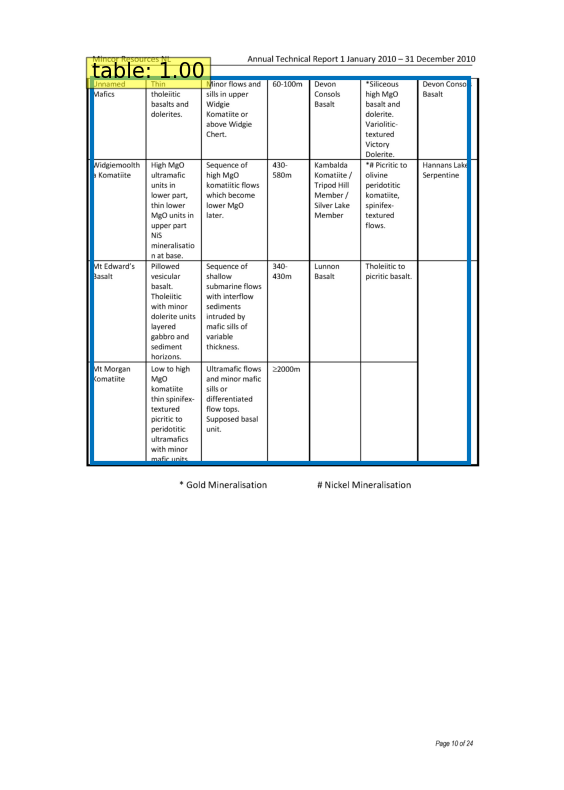

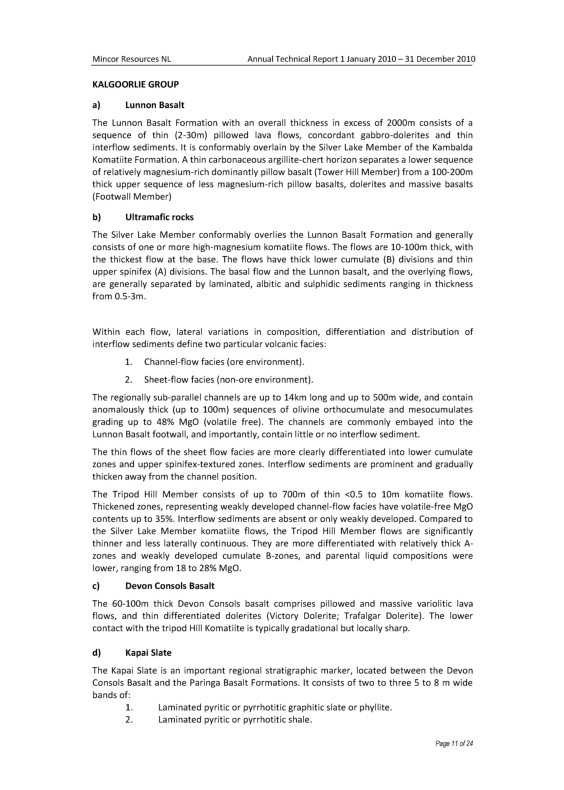

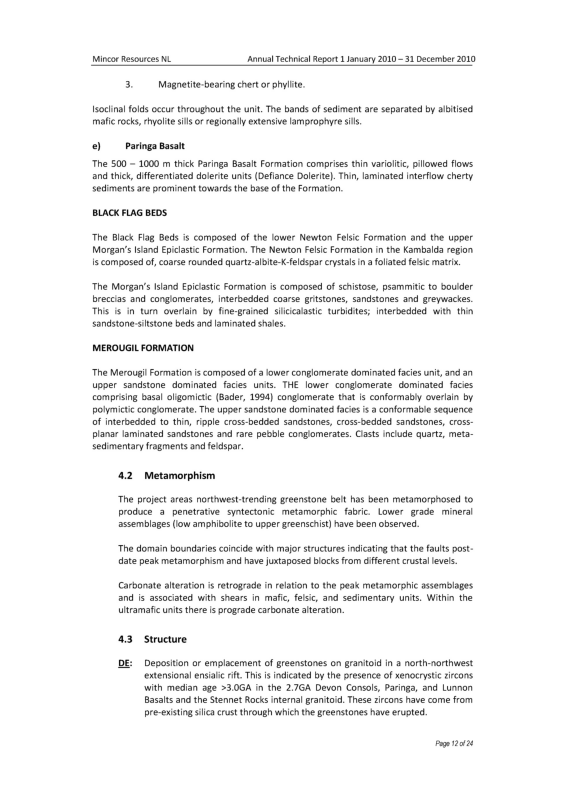

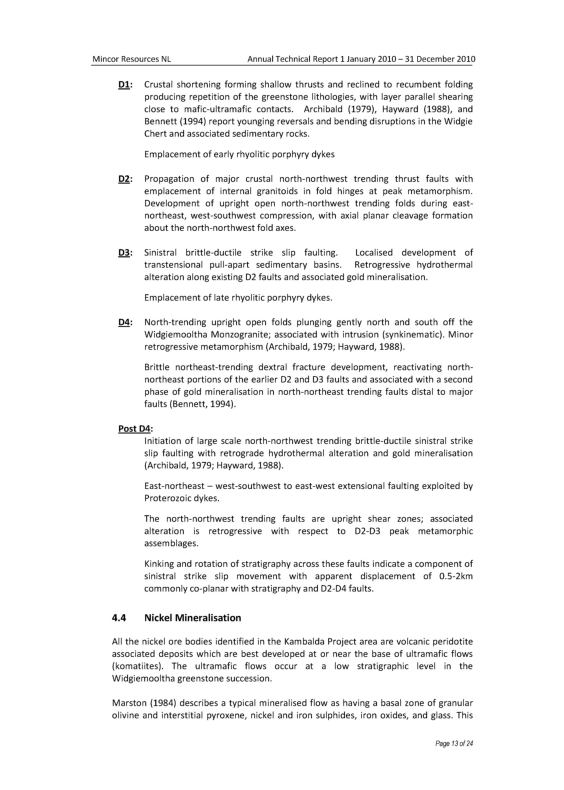

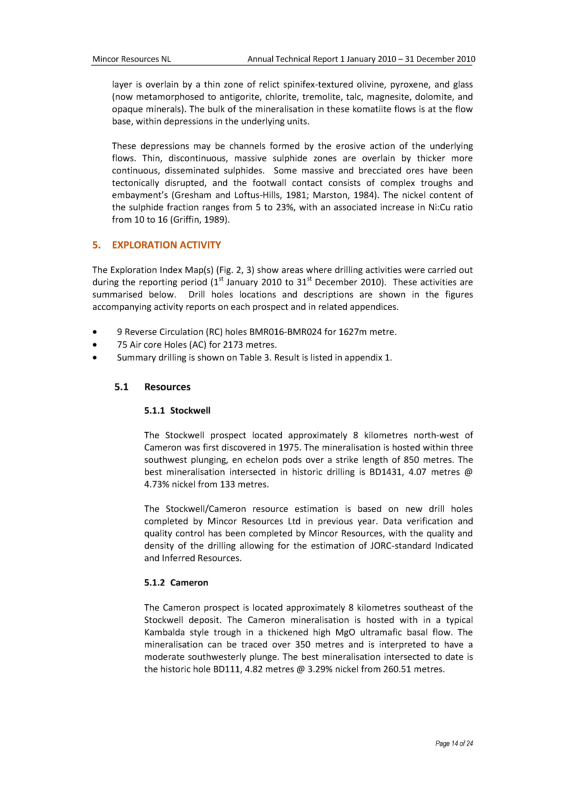

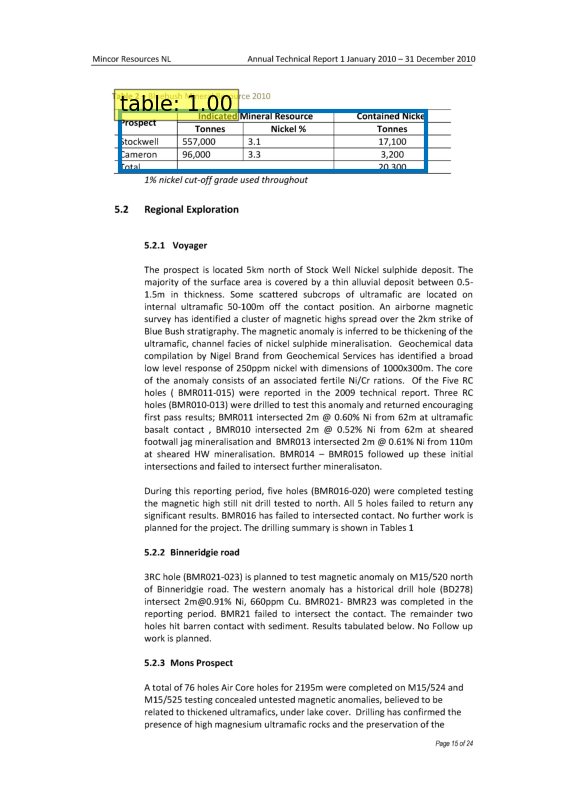

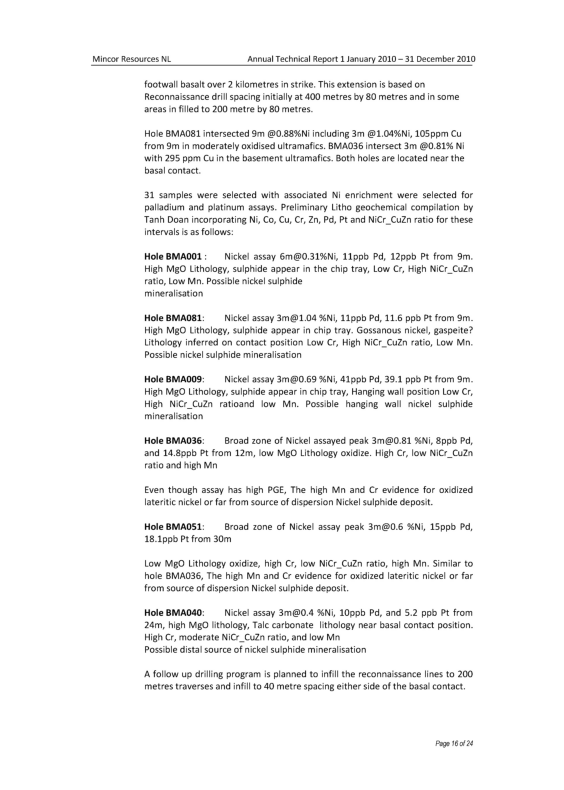

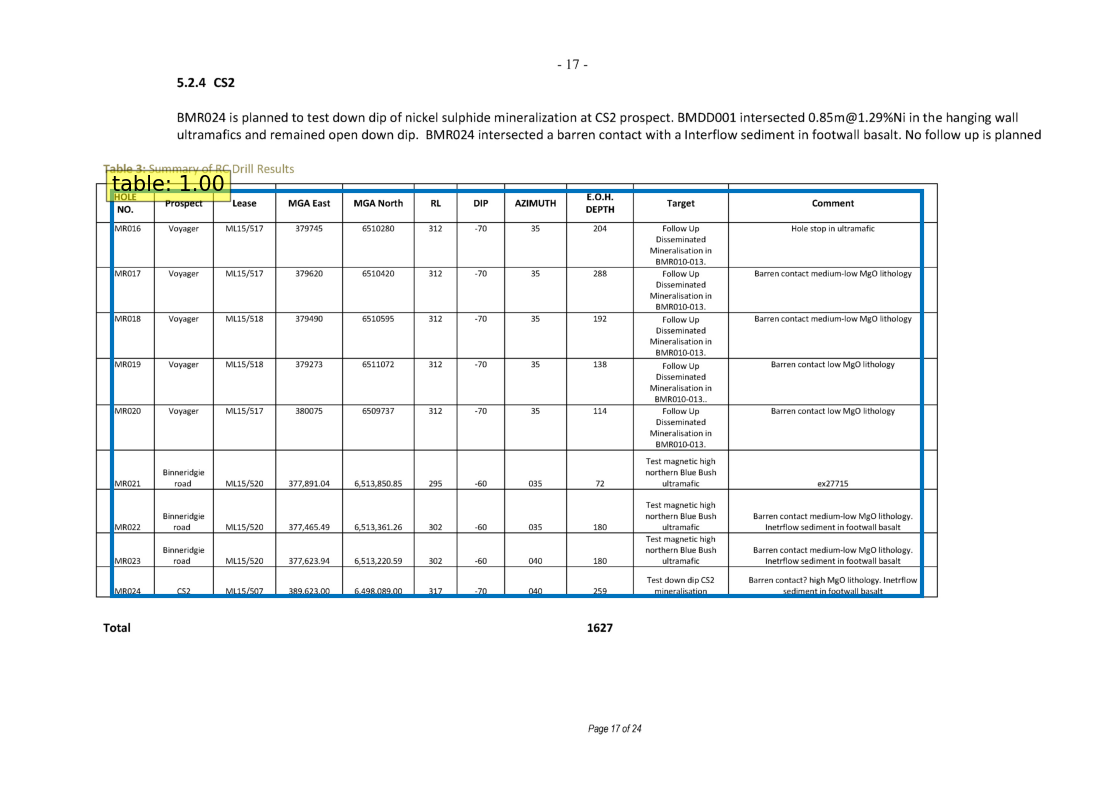

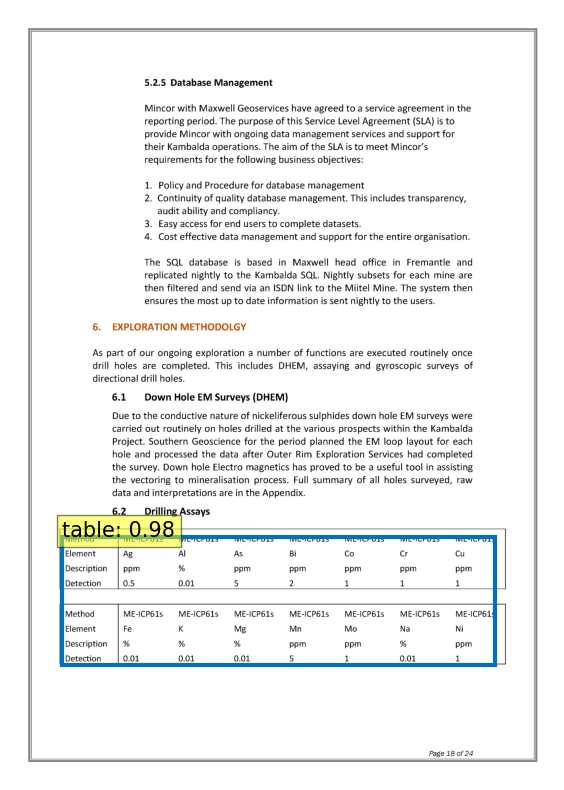

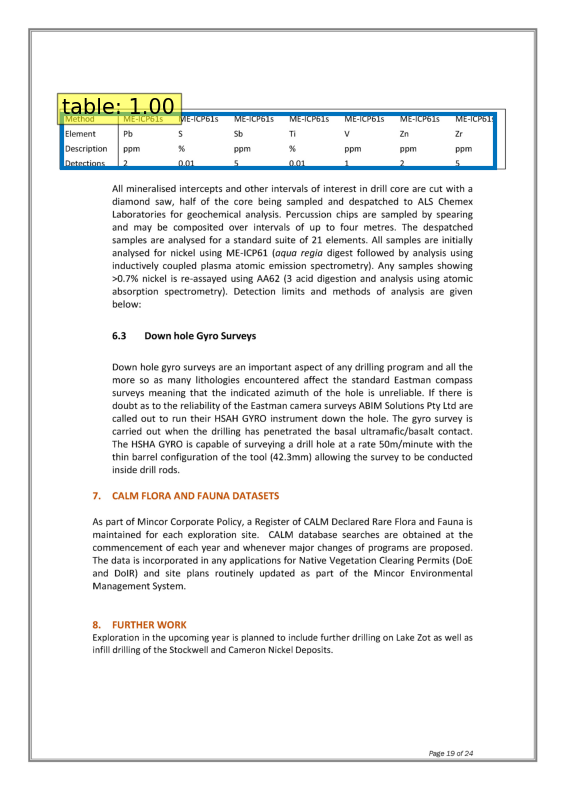

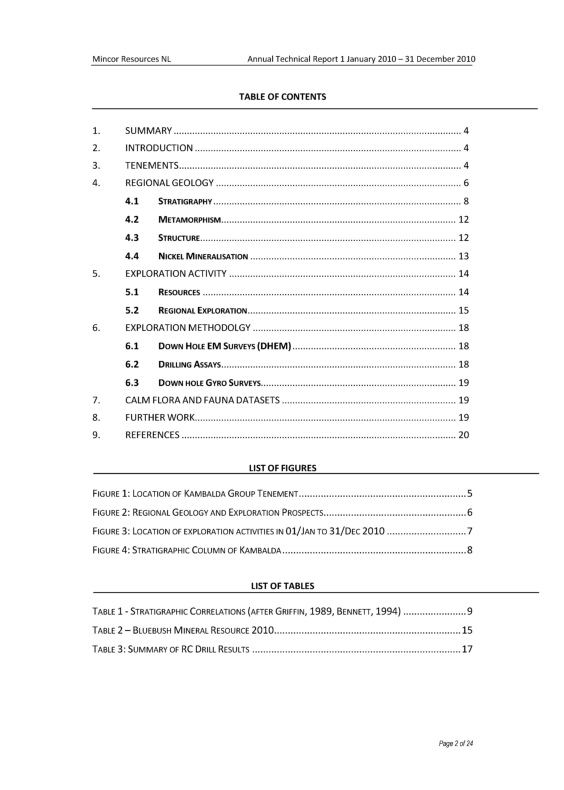

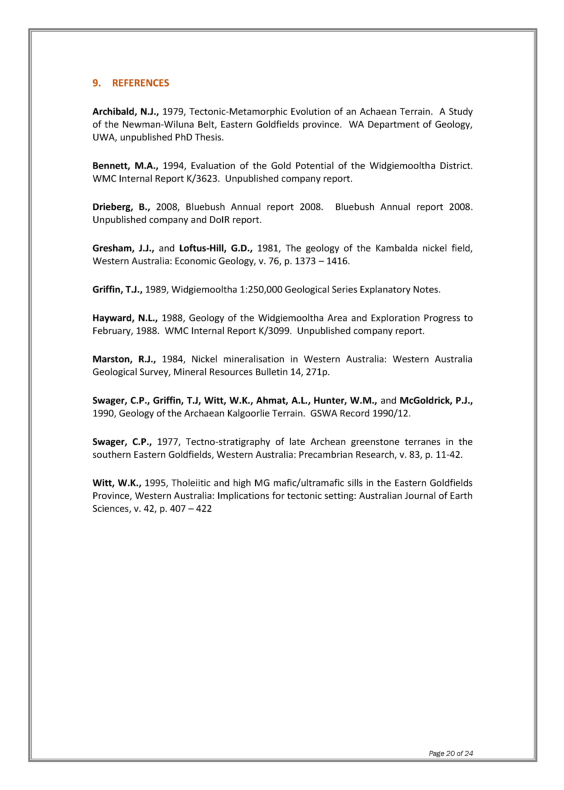

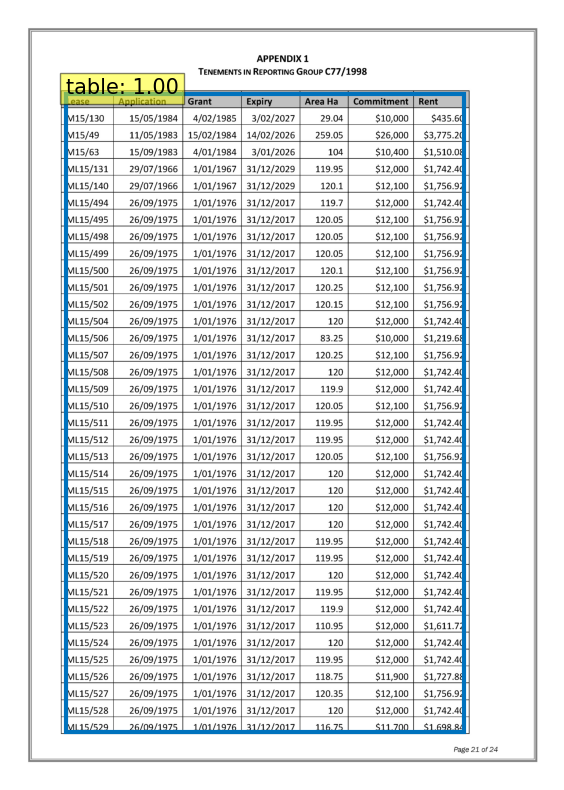

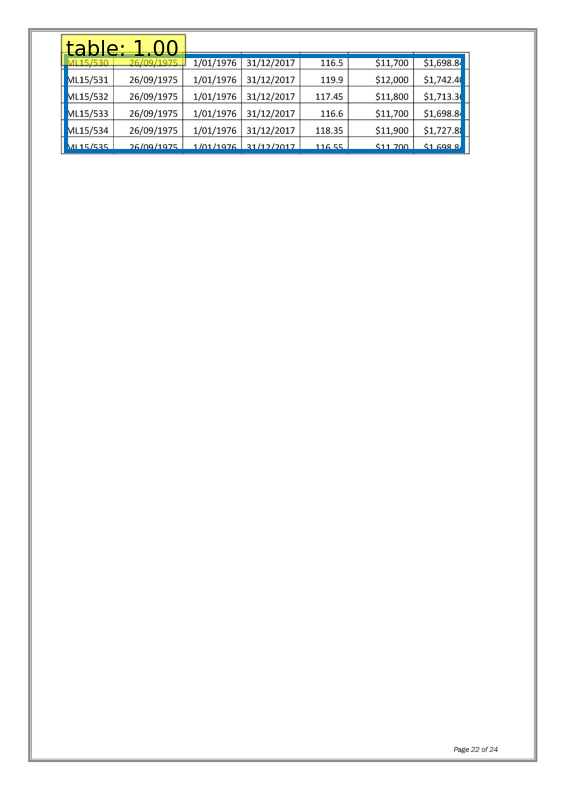

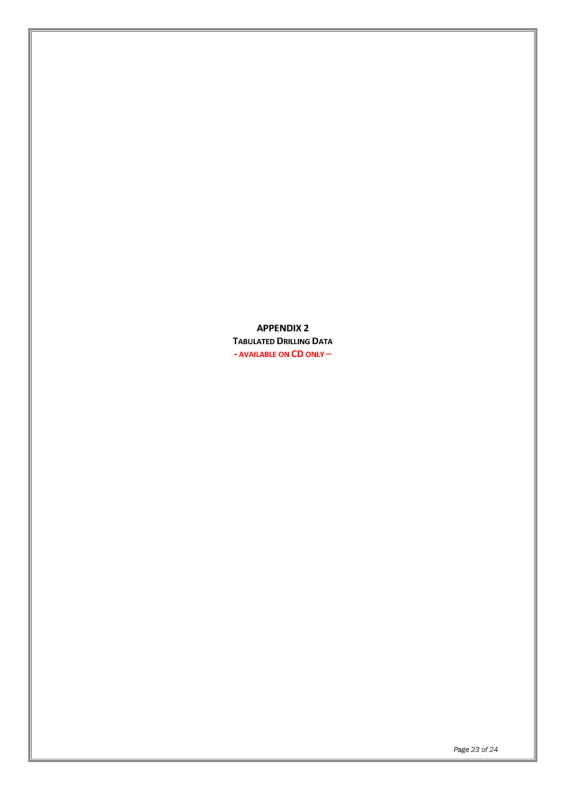

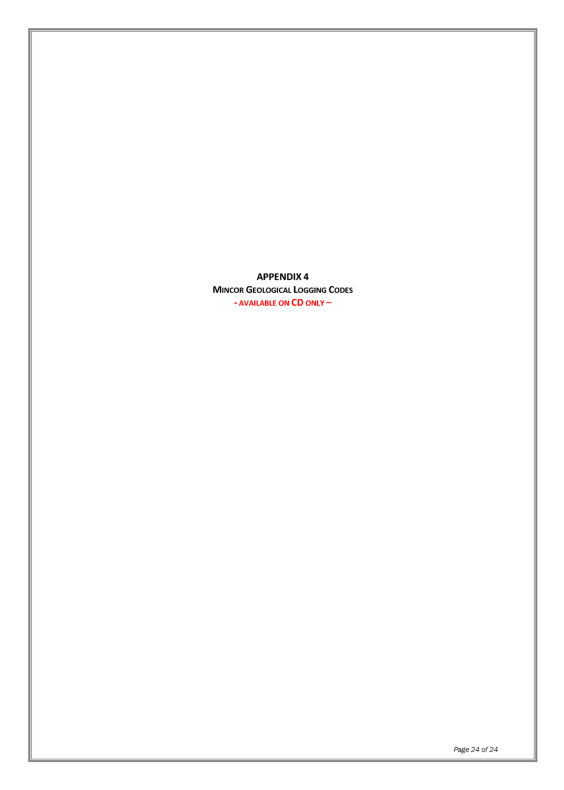

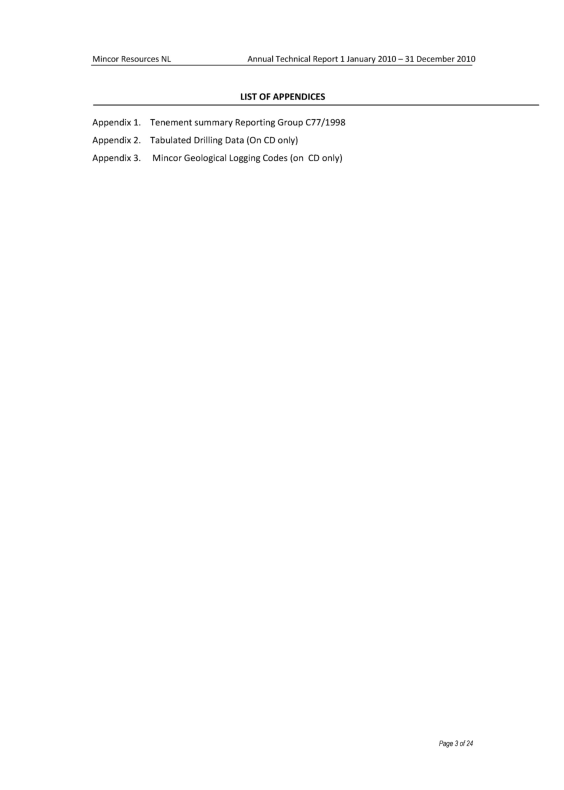

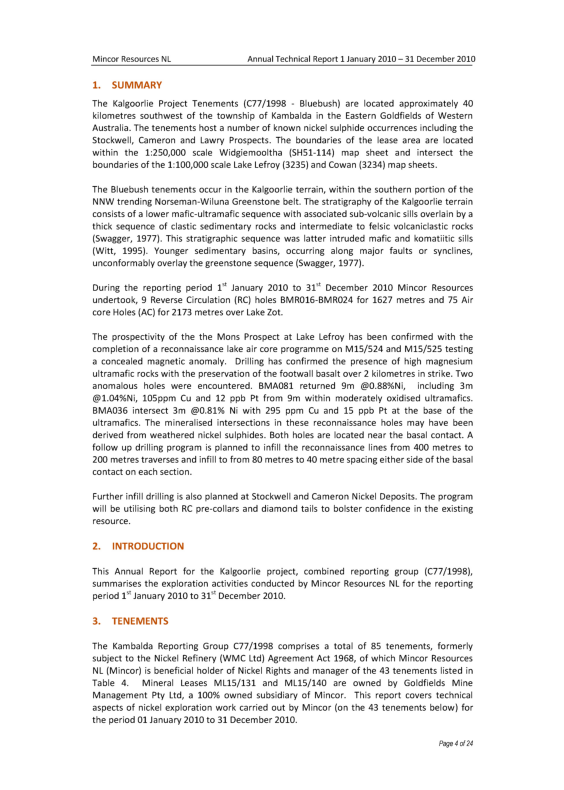

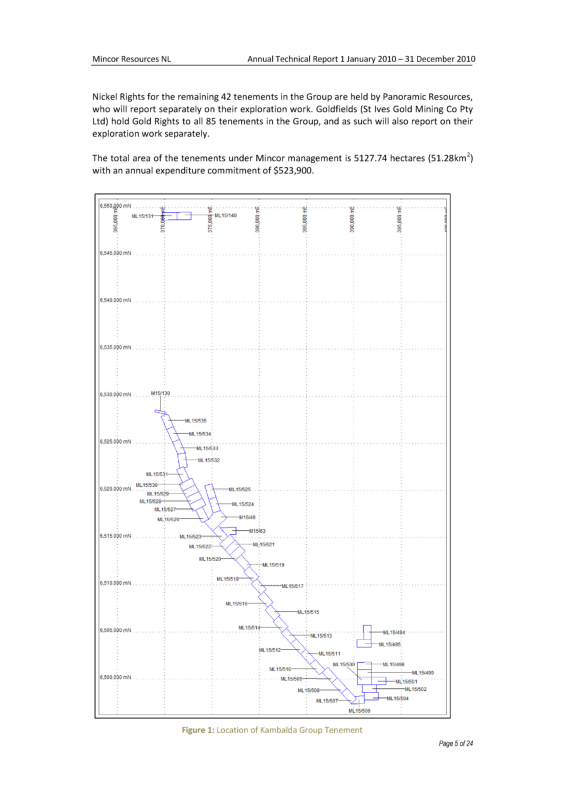

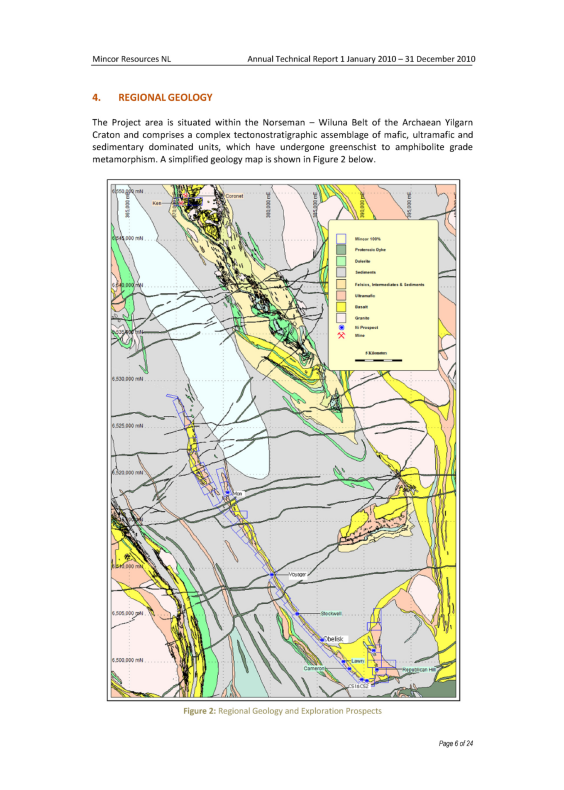

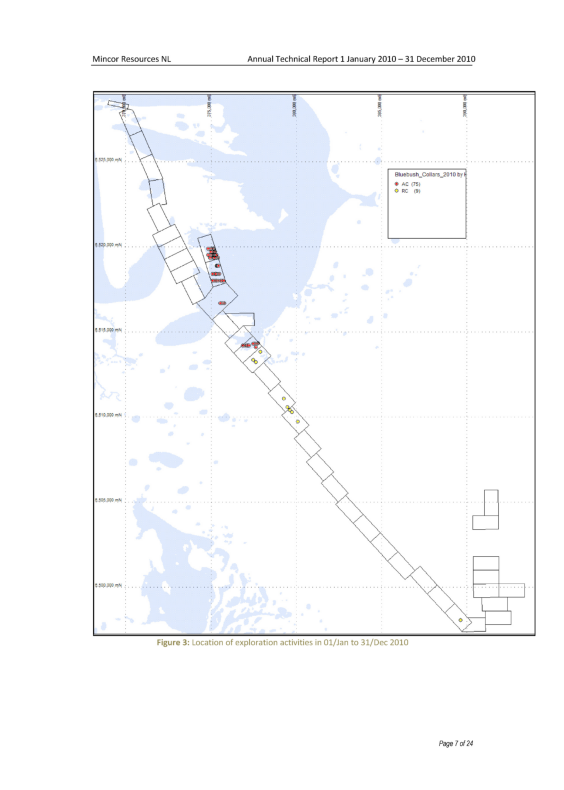

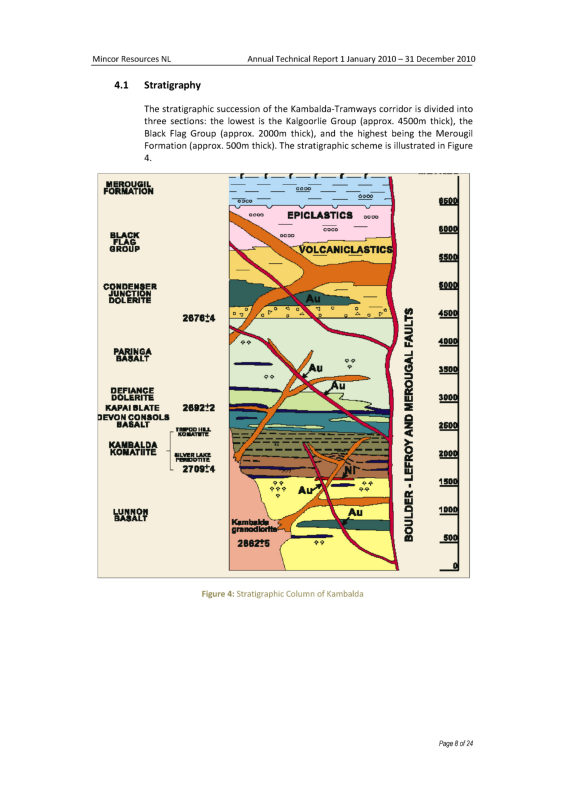

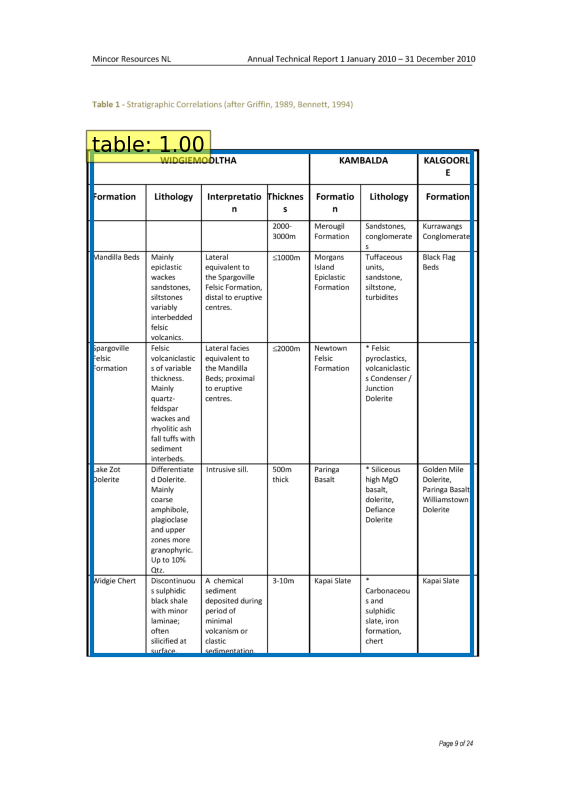

In [4]:
## Table Recognition

# Define Model and Feature Extractor outside loop since they don't need to be redefined for each image
feature_extractor = DetrFeatureExtractor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

# Define COLORS for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# Function to process and plot results for an image
def process_image(file_name):
    image = Image.open(file_name).convert("RGB")
    width, height = image.size
    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    # Rescale bounding boxes
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.97, target_sizes=[(height, width)])[0]

    # Turn On For Example:
    
    plot_results(image, results['scores'], results['labels'], results['boxes'])
    
    # Save bounding boxes to a JSON file
    save_to_json(file_name, results)

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def save_to_json(file_name, results):
    structured_results = []

    # Convert tensors to lists (assuming you are using PyTorch tensors)
    scores = results['scores'].tolist()
    labels = results['labels'].tolist()
    boxes = [box.tolist() for box in results['boxes']]

    for score, label, box in zip(scores, labels, boxes):
        structured_results.append({
            "score": score,
            "label": label,
            "box": {
                "x1": box[0],
                "y1": box[1],
                "x2": box[2],
                "y2": box[3]
            }
        })

    json_output = json.dumps(structured_results, indent=4)

    # Remove .jpg from the filename if it exists
    sanitized_file_name = file_name.replace(".jpg", "")
    
    # Use an f-string for filename formatting
    with open(f"{sanitized_file_name}.json", "w") as file:
        file.write(json_output)


# Process each image
for image_file in all_files:
    process_image(image_file)

### 2. Extract Table Images Using Table Recognition Bounds

In [5]:
def extract_tables_from_image(image_path, base_save_path, buffer=70):  # Added buffer parameter with a default value of 10 pixels

    img = cv2.imread(image_path)

    # Use the base image name as the directory name for cropped images
    base_image_name = os.path.basename(image_path).split('.')[0]
    specific_save_path = os.path.join(base_save_path, base_image_name)
    
    # Create the directory if it doesn't exist
    if not os.path.exists(specific_save_path):
        os.makedirs(specific_save_path)

    with open(image_path.replace('.jpg', '.json'), 'r') as j:

        data = json.load(j)
        boxes = [entry['box'] for entry in data]  # Assuming the 'boxes' key holds the bounding box data

    for index, box in enumerate(boxes):
        x1 = int(box['x1'])
        y1 = int(box['y1'])
        x2 = int(box['x2'])
        y2 = int(box['y2'])
        
        # Apply buffer
        x1 = max(0, x1 - buffer)
        y1 = max(0, y1 - buffer)
        x2 = min(img.shape[1], x2 + buffer)  # img.shape[1] gives the width
        y2 = min(img.shape[0], y2 + buffer)  # img.shape[0] gives the height
        
        cropped_img = img[y1:y2, x1:x2]
            
        cv2.imwrite(f"{specific_save_path}/{base_image_name}_table_{index}.png", cropped_img)


def main(directory_path, base_save_path):
    # Get all jpg images in the directory
    image_files = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

    for image_file in image_files:
        # Construct path for image
        image_path = os.path.join(directory_path, image_file)
        # Extract tables from image
        extract_tables_from_image(image_path, base_save_path)


# Get the current directory
current_directory = os.getcwd()

# Get the parent directory path
parent_directory = os.path.dirname(current_directory)

# Extract the parent folder name
parent_folder_name = os.path.basename(parent_directory)

main(main_wd, f"{parent_folder_name} Cropped Images")

### 3. Perform Table Structure Recognition

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_1\90098_1_table_0.png


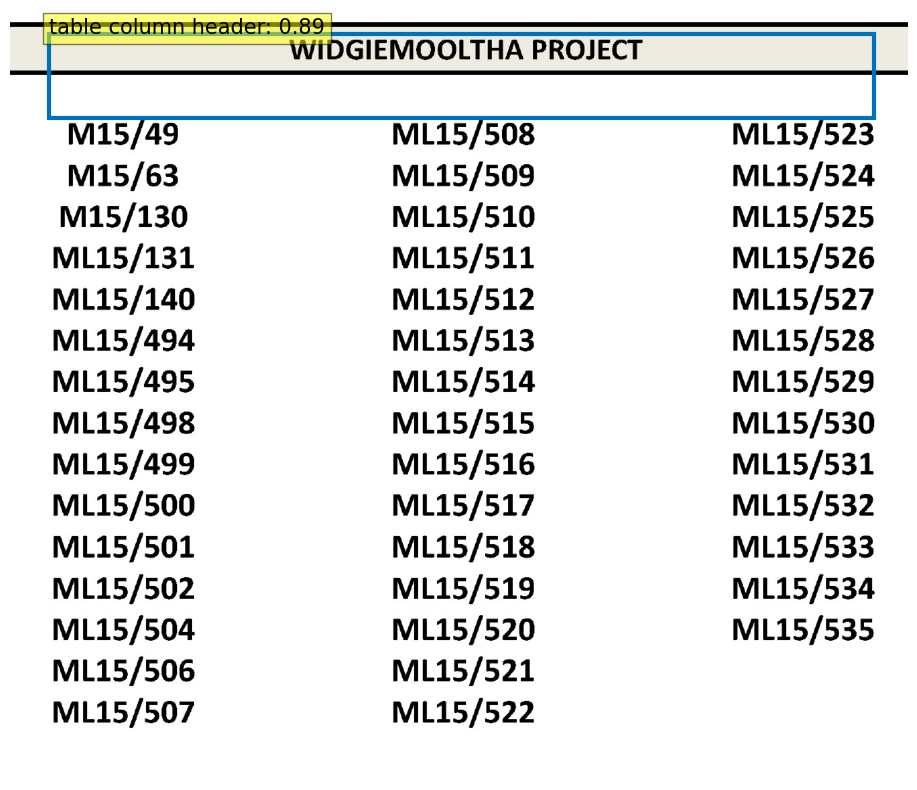

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_10\90098_10_table_0.png


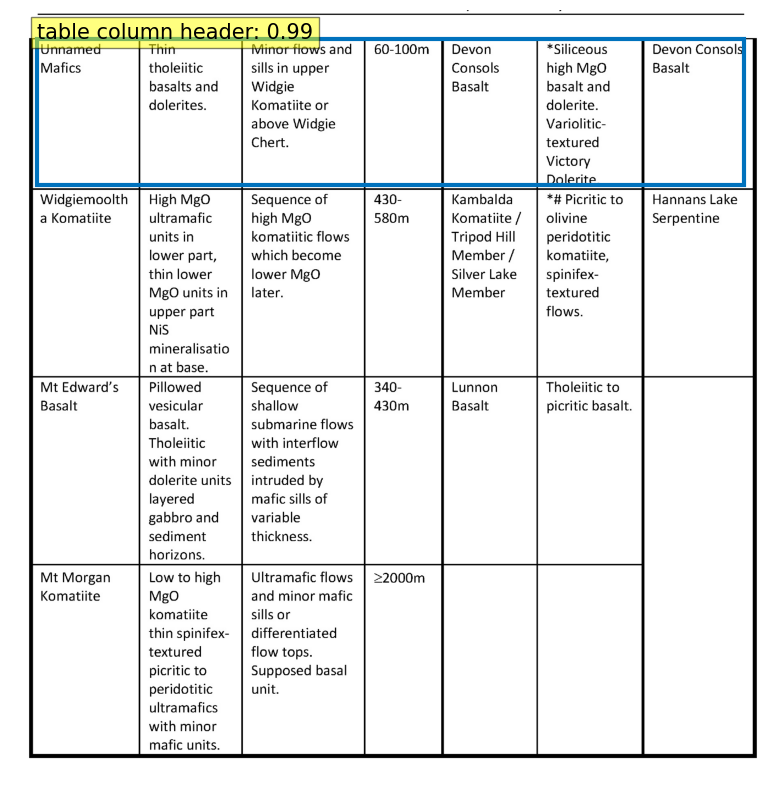

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_15\90098_15_table_0.png


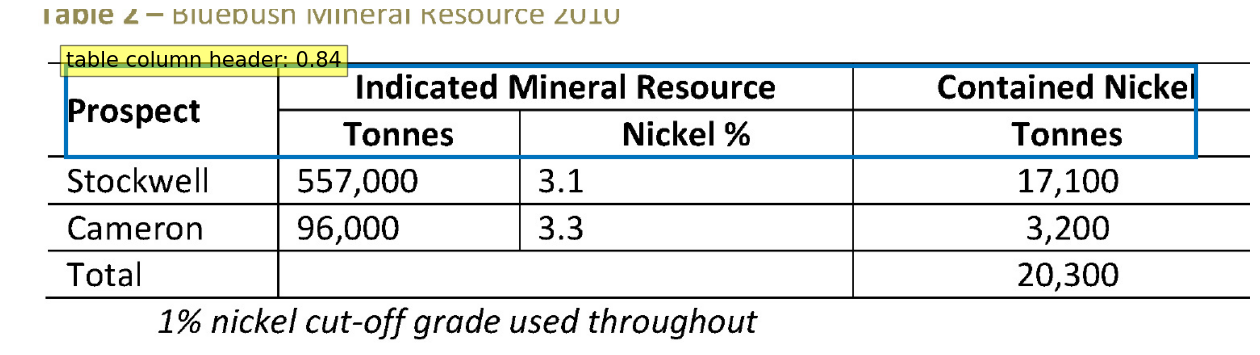

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_17\90098_17_table_0.png


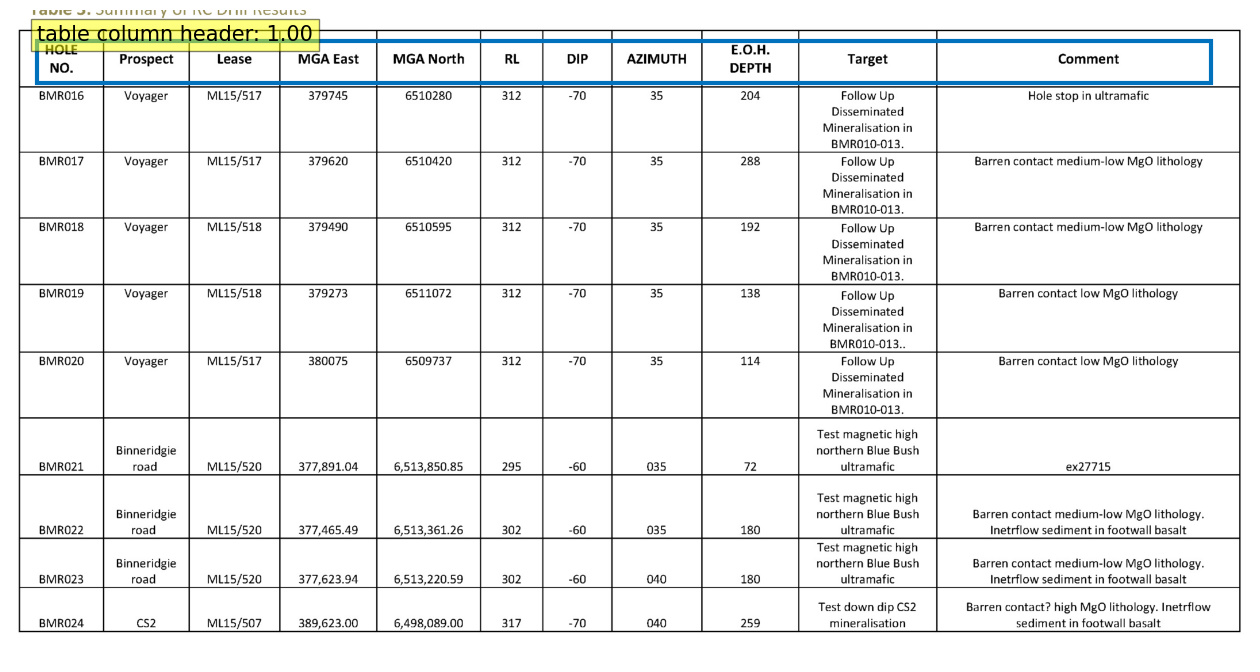

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_18\90098_18_table_0.png


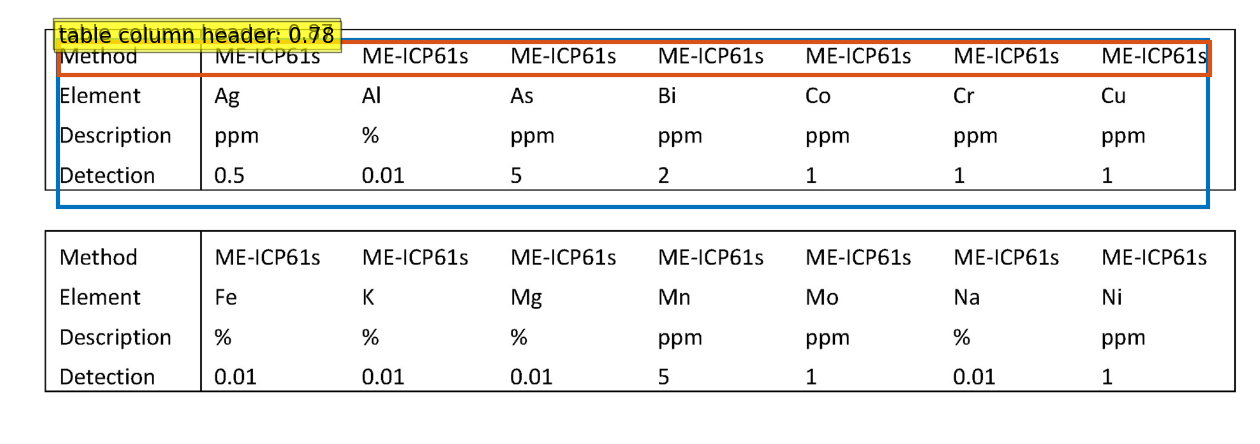

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_19\90098_19_table_0.png


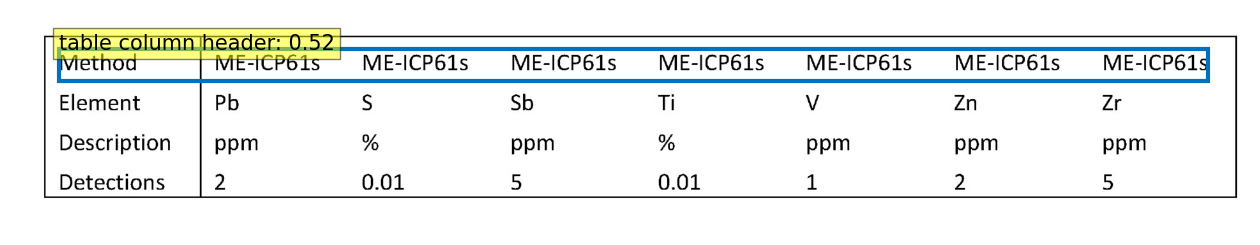

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_21\90098_21_table_0.png


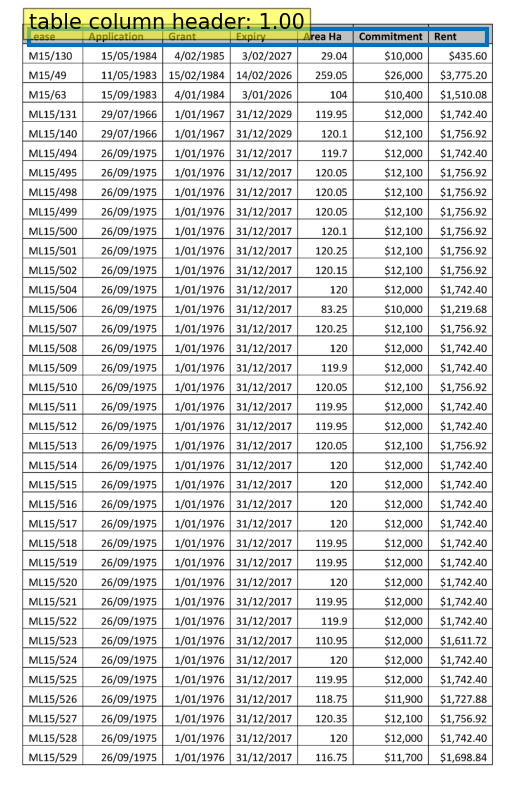

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_22\90098_22_table_0.png


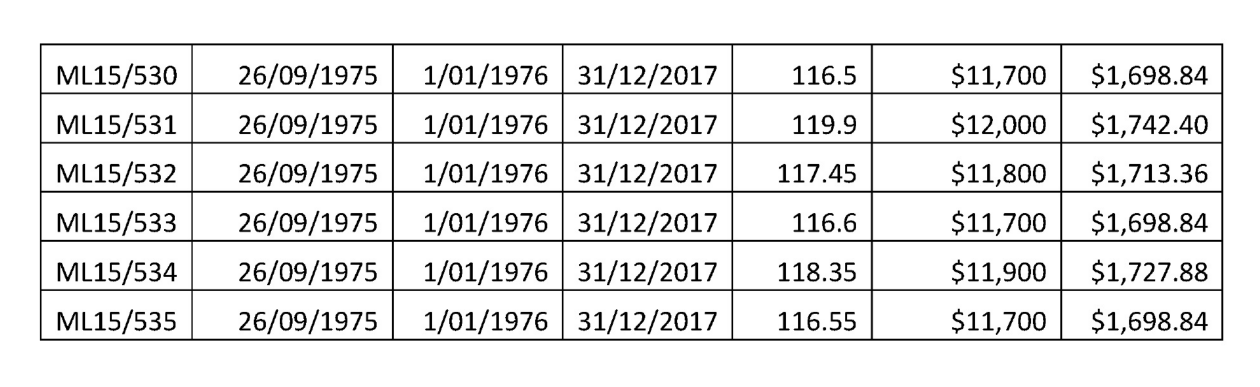

Processing image: D:/UWA/cits5553/Dataset/Kose/90098\Kose Cropped Images\90098_9\90098_9_table_0.png


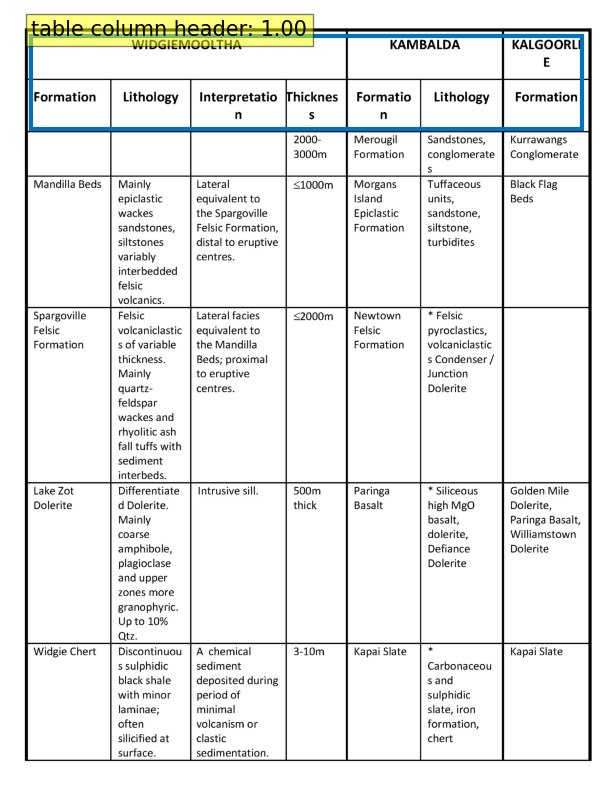

In [23]:
import os
from PIL import Image, ImageDraw

def get_cropped_image_dir(base_directory):
    return next(
        (d for d in os.listdir(base_directory) 
         if "Cropped Images" in d and os.path.isdir(os.path.join(base_directory, d))), 
        None
    )

def save_cropped_regions(image, boxes, output_folder):
    for idx, box in enumerate(boxes):
        left, top, right, bottom = map(int, box)
        cropped_image = image.crop((left, top, right, bottom))
        cropped_image.save(os.path.join(output_folder, f"region_{idx}.jpg"))

def process_image(image_file_path, model, feature_extractor):
    print(f"Processing image: {image_file_path}")

    image = Image.open(image_file_path).convert("RGB")
    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    target_sizes = [image.size[::-1]]
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

    # Plotting with selected labels
    filtered_labels = results['labels'][results['labels'] == 3]
    filtered_boxes = results['boxes'][results['labels'] == 3]
    filtered_scores = results['scores'][results['labels'] == 3]
    plot_results(image, filtered_scores, filtered_labels, filtered_boxes)


    # Plotting all the labels together
    # plot_results(image, results['scores'], results['labels'], results['boxes'])
    save_to_json(image_file_path, results)

    # Assuming boxes in 'results' gives you the desired rows and columns
    boxes = results['boxes']

    # Extract the rows/columns and save them
    output_folder = os.path.join(os.path.dirname(image_file_path), "Extracted_Regions")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    save_cropped_regions(image, boxes, output_folder)

# Setup the Table Transformer Structure Recognition Model
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

base_directory = main_wd
# base_directory = 'D:/UWA/cits5553/Dataset/Table_trial'
cropped_image_dir = get_cropped_image_dir(base_directory)
model.config.id2label

if not cropped_image_dir:
    print("Directory containing 'Cropped Images' not found.")
    exit()

cropped_image_path = os.path.join(base_directory, cropped_image_dir)

# Loop through all the subfolders
for subfolder in sorted(os.listdir(cropped_image_path)):
    subfolder_path = os.path.join(cropped_image_path, subfolder)
    if os.path.isdir(subfolder_path):
        # Loop through all the image files in the current subfolder
        for image_file in sorted(os.listdir(subfolder_path)):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_file_path = os.path.join(subfolder_path, image_file)
                process_image(image_file_path, model, feature_extractor)


In [7]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [10]:
# For simple tables with no spanning cells

test_path = "D:/UWA/cits5553/Dataset/Kose/90098/Kose Cropped Images/90098_21"
table_name = os.path.basename(test_path)

json_path = os.path.join(test_path, f"{table_name}_table_0.png.json")

# Open JSON file
with open(json_path, 'r') as json_file:
    data = json.load(json_file)

# Access the table data which has label = 1 (columns)
column_data = [(idx, item) for idx, item in enumerate(data) if item.get("label") == 1]

# Access the table data which has label = 2 (rows)
row_data = [(idx, item) for idx, item in enumerate(data) if item.get("label") == 2]

col_len = len(column_data)
row_len = len(row_data)
cell_number = col_len * row_len

# Finding the order of rows and columns
#sorted_indices = sorted(range(len(row_data)), key=lambda idx: row_data[1]['box']['x1'])

# Print the sorted indices
#print("Order of indices by x1 values in ascending order:", sorted_indices)
import pandas as pd

def recreate_table(data, check): 

    result_tuples = [(item[0], item[1]['box']['x1']) for item in data]
    sorted_tuples = sorted(result_tuples, key=lambda tuple_item: tuple_item[1])
    index_list = [item[0] for item in sorted_tuples]

    table_dict = {}
    for idx in index_list:
        image_path = os.path.join(test_path, f"Extracted_Regions/region_{idx}.jpg")
        lines = [line for line in pytesseract.image_to_string(image_path).split('\n') if line.strip() != ""]
        if len(lines) < check:
            lines.extend([None] * (check - len(lines)))
        table_dict[lines[0]] = lines[1:]
    
    table = pd.DataFrame(table_dict)
    return table

new_table = recreate_table(column_data, row_len)

new_table.to_csv("D:/UWA/cits5553/output2.csv")


# # Reading up and verifying the column data
# for idx, item in column_data:
#     image_path = os.path.join(test_path, f"Extracted_Regions/region_{idx}.jpg")
#     lines = [line for line in pytesseract.image_to_string(image_path).split('\n') if line.strip() != ""]
#     print(lines)

# # Spacing between column and rows
# #print("\n")

# # Reading up and verifying the row data
# for idx, item in row_data:
#     image_path = os.path.join(test_path, f"Extracted_Regions/region_{idx}.jpg")
#     lines = [line for line in pytesseract.image_to_string(image_path).split('\n') if line.strip() != ""]
#     #print(lines)

#pytesseract.image_to_string("D:/UWA/cits5553/Dataset/Kose/90098/Kose Cropped Images/90098_19/Extracted_Regions/region_5.jpg").rstrip().split('\n')

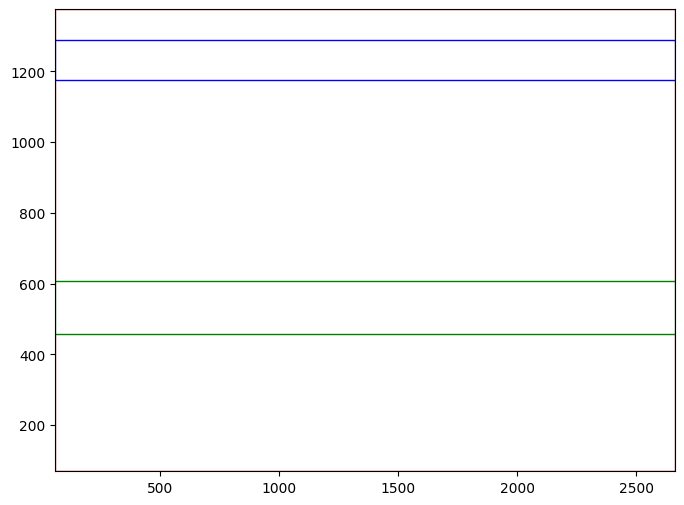

In [ ]:
# test_path = "D:/UWA/cits5553/Dataset/Kose/90098/Kose Cropped Images/90098_17/90098_17_table_0.png.json"

# # Open JSON file
# with open(test_path, 'r') as json_file:
#     data = json.load(json_file)

# # Access the table data which has label = 0
# table_data = [item for item in data if item["label"] == 0]

# data[0]["box"]

# # Create a white canvas
# fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed

# # # Plot the white background
# ax.fill([table_data[0]["box"]['x1'], table_data[0]["box"]['x2'], table_data[0]["box"]['x2'], table_data[0]["box"]['x1']],
#         [table_data[0]["box"]['y1'], table_data[0]["box"]['y1'], table_data[0]["box"]['y2'], table_data[0]["box"]['y2']],
#         color='white', edgecolor='red')

# ax.fill([data[0]["box"]['x1'], data[0]["box"]['x2'], data[0]["box"]['x2'], data[0]["box"]['x1']],
#         [data[0]["box"]['y1'], data[0]["box"]['y1'], data[0]["box"]['y2'], data[0]["box"]['y2']],
#         color='white', edgecolor='blue')

# ax.fill([data[1]["box"]['x1'], data[1]["box"]['x2'], data[1]["box"]['x2'], data[1]["box"]['x1']],
#         [data[1]["box"]['y1'], data[1]["box"]['y1'], data[1]["box"]['y2'], data[1]["box"]['y2']],
#         color='white', edgecolor='green')

# # # Set the axis limits based on the table_data[0]["box"]
# ax.set_xlim(table_data[0]["box"]['x1'], table_data[0]["box"]['x2'])
# ax.set_ylim(table_data[0]["box"]['y1'], table_data[0]["box"]['y2'])

# # Add labels or other plot elements if needed

# # Show the plot
# plt.show()


In [ ]:
# import html

# from IPython.display import HTML

# # Define your data as a list of rows, where each row is a list of cells
# data = [
#     ["Header 1", "Header 2", "Header 3"],
#     ["Row 1, Cell 1", "Row 1, Cell 2", "Row 1, Cell 3"],
#     ["Row 2, Cell 1", "Row 2, Cell 2", "Row 2, Cell 3"],
# ]

# # Create an HTML table
# html_table = "<table>\n"

# # Adding spanning cell in the second row and third column
# data[1][2] = f"<td rowspan='2'>{html.escape(data[1][2])}</td>"

# for row in data:
#     html_table += "  <tr>\n"
#     for cell in row:
#         html_table += f"    {cell}\n"
#     html_table += "  </tr>\n"

# html_table += "</table>"

# # Print or save the HTML table as needed
# HTML(html_table)


In [ ]:
print(pytesseract.image_to_string(Image.open("D:/UWA/cits5553/Dataset/Kose/90098/Kose Cropped Images/90098_17/90098_17_table_0.png")))

PAMIS we SUITITTTICH Y Wi INN RAEEE INCOUIO

E.O.H.
Prospect AZIMUTH DEPTH Target Comment

BMRO16 Voyager ML15/517 379745 6510280 Follow Up Hole stop in ultramafic
Disseminated
Mineralisation in
BMRO10-013.
Follow Up Barren contact medium-low MgO lithology
Disseminated
Mineralisation in
BMRO10-013.

BMRO17 Voyager ML15/517 379620 6510420

BMRO18 ML15/518 379490 6510595
BMRO19 ML15/518 379273 6511072

Follow Up Barren contact medium-low Mgo lithology
Disseminated
Mineralisation in
BMR010-013.
Follow Up Barren contact low MgO lithology
Disseminated
Mineralisation in
BMRO10-013..

Test magnetic high
northern Blue Bush
ultramafic ex27715

Binneridgie

BMRO21 road ML15/520 377,891.04 6,513,850.85
Binneridgie

BMR022 road ML15/520 377,465.49 6,513,361.26

Binneridgie
BMR023 road ML15/520 377,623.94 6,513,220.59
BMRO24 ML15/507 389,623.00 6,498,089.00

Test magnetic high

northern Blue Bush Barren contact medium-low Mgo lithology.
ultramafic Inetrflow sediment in footwall basalt
Test magnetic

In [9]:
import os
import pandas as pd
import pytesseract
from PIL import Image

# Set directory to where tesseract.exe is installed
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

def ocr_image_to_text(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)
    return text

def text_to_dataframe(text):
    # Split the text by lines
    lines = text.strip().split("\n")
    data = []
    for line in lines:
        # Further split each line by spaces to get individual columns
        # This might need adjustment depending on the table format
        data.append(line.split())
    df = pd.DataFrame(data)
    return df

# Directory to where the cropped images are at
base_directory = "D:/UWA/cits5553/Dataset/Kose/90098/Kose Cropped Images/90098_17"

all_dataframes = []

# Loop through all the subfolders
for subfolder in sorted(os.listdir(base_directory)):
    subfolder_path = os.path.join(base_directory, subfolder)
    if os.path.isdir(subfolder_path):
        # Loop through all the image files in the current subfolder
        for image_file in sorted(os.listdir(subfolder_path)):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_file_path = os.path.join(subfolder_path, image_file)
                recognized_text = ocr_image_to_text(image_file_path)
                print(recognized_text)
                # df = text_to_dataframe(recognized_text)
                # all_dataframes.append(df)

# Now you have a list of dataframes in all_dataframes


Test magnetic high
Binneridgie northern Blue Bush Barren contact medium-low Mgo lithology.
BMRO23 road ML15/520 377,623.94 6,513,220.59 302 -60 040 180 ultramafic Inetrflow sediment in footwall basalt


BMRO18 Voyager ML15/518 379490 6510595 312 -70 35 192 Follow Up Barren contact medium-low Mgo lithology
Disseminated
Mineralisation in
BMRO10-013.

MGA North

6510280

6510420

6510595

6511072

6509737

6,513,850.85

6,513,361.26

6,513,220.59

6,498,089.00

MGA East

379745

379620

379490

379273

380075

377,891.04

377,465.49

377,623.94

389,623.00

RL

312

312

312

312

312

295

302

302

317


HOLE

No. AZIMUTH

Prospect Target Comment

Lease | MGA East

MGA North | RL | DIP


Target

Follow Up
Disseminated
Mineralisation in
BMRO10-013.
Follow Up
Disseminated
Mineralisation in
BMRO10-013.

Follow Up
Disseminated
Mineralisation in
BMRO10-013.
Follow Up
Disseminated
Mineralisation in
BMRO10-013..
Follow Up
Disseminated
Mineralisation in
BMRO10-013.

Test magnetic high
northern 

In [ ]:
print(all_dataframes)

[            0         1         2           3             4        5   \
0         Test  magnetic      high        None          None     None   
1  Binneridgie  northern      Blue        Bush        Barren  contact   
2       BMRO23      road  ML15/520  377,623.94  6,513,220.59      302   

           6     7           8           9          10        11    12  \
0        None  None        None        None       None      None  None   
1  medium-low   Mgo  lithology.        None       None      None  None   
2         -60   040         180  ultramafic  Inetrflow  sediment    in   

         13      14  
0      None    None  
1      None    None  
2  footwall  basalt  ,                0        1         2       3        4     5     6     7     8   \
0          BMRO18  Voyager  ML15/518  379490  6510595   312   -70    35   192   
1    Disseminated     None      None    None     None  None  None  None  None   
2  Mineralisation       in      None    None     None  None  None  None  None